In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
class AntColonyOptimizer:

    def __init__(self, sets_list, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0,
                 beta_evaporation_rate=0, mutation=0.01, tmax=100):
        self.sets_list = sets_list
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.intensification = intensification
        self.alpha = alpha
        self.beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.mutation = mutation
        self.tmax = tmax

        self.n = len(sets_list)
        self.universe_size = len(set([x for y in sets_list for x in y]))

        # self.pheromone_matrix = self.adj_matrix.A1.reshape(self.n, self.n).astype(float)
        self.pheromone_matrix = np.ones((self.n, self.n))
        self.pheromone_matrix[np.eye(self.n) == 1] = 0

        set_lengths = [len(s) for s in sets_list]

        assert len(set_lengths) == self.n

        self.heuristic_matrix = np.array(set_lengths)
        self.heuristic_matrix = np.tile(self.heuristic_matrix, self.n)
        self.heuristic_matrix = self.heuristic_matrix.reshape(self.n, self.n)
        self.heuristic_matrix[np.eye(self.n) == 1] = 0

        self.prob_matrix = None
        self._update_probabilities()

        self.best_series = []
        self.best_solution = None
        self.best_score = self.n + 1

    def _update_probabilities(self):
        self.prob_matrix = (self.pheromone_matrix ** self.alpha) * (self.heuristic_matrix ** self.beta)

    def _chose_next_node(self, curr_node, available_nodes):
        numerator = self.prob_matrix[curr_node, available_nodes]
        denominator = np.sum(numerator)
        if np.random.rand() < self.mutation or denominator == 0:
            return np.random.choice(range(len(available_nodes)))
        else:
            probabilities = numerator / denominator
            return np.random.choice(range(len(probabilities)), p=probabilities)

    def _is_valid_solution(self, solution):
        s = [self.sets_list[i] for i in solution]
        flat_set = set([x for y in s for x in y])
        # print(flat_set)
        return len(flat_set) == self.universe_size

    def _evaluate(self, solutions):
        x_coords = None
        y_coords = None
        best_solution = None
        best_score = self.n + 1
        for s in solutions:
            if len(s) < best_score:
                best_score = len(s)
                best_solution = s
                x_coords = []
                y_coords = []
                for i in range(len(s) - 1):
                    x_coords.append(s[i])
                    y_coords.append(s[i + 1])

        return (x_coords, y_coords), best_solution, best_score

    def _evaporation(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, coords):
        x = coords[0]
        y = coords[1]
        self.pheromone_matrix[x, y] += self.intensification

    def fit(self):
        for t in range(self.tmax):
            solutions = []
            for ant in range(self.ants):
                solution = []
                available_nodes = list(range(self.n))
                curr_node = available_nodes[np.random.randint(0, len(available_nodes))]

                while True:
                    solution.append(curr_node)
                    available_nodes.remove(curr_node)
                    if self._is_valid_solution(solution):
                        break
                    else:
                        curr_node_idx = self._chose_next_node(curr_node, available_nodes)
                        curr_node = available_nodes[curr_node_idx]

                solutions.append(solution)

            best_solution_coords, best_solution, best_score = self._evaluate(solutions)

            if best_score < self.best_score:
                self.best_score = best_score
                self.best_solution = best_solution

            self.best_series.append(best_score)

            self._evaporation()
            self._intensify(best_solution_coords)
            self._update_probabilities()

            print(f'Iteration {t + 1}/{self.tmax}: Best Score = {best_score}, Global Best Score = {self.best_score}')

        print(f'Best fit: Score = {self.best_score}, Solution = {[self.sets_list[i] for i in self.best_solution]}')
        plt.figure(figsize=(18, 12))
        plt.plot(self.best_series)
        plt.show()


In [5]:
sets = [{1, 2},  {2, 3}, {3, 5}, {4}, {3, 4, 5, 6}, {1, 7}, {8, 2}]


U = list(range(1, 100))
S = [{62}, {66, 74, 79, 18, 19}, {56}, {70, 79, 59, 92, 94}, {52, 15}, {23}, {1, 86, 25}, {99, 49, 67, 9}, {50, 30}, {72, 49, 78}, {96, 10, 5}, {31}, {26}, {7, 15, 88, 30, 63}, {56, 76, 61, 14}, {83, 20, 5, 78}, {25, 59, 35, 63}, {65, 4, 37, 36, 25}, {84}, {69, 85, 54, 55, 94}, {54, 2, 20, 44}, {1, 26, 44, 69}, {81, 51, 68, 71}, {75, 36, 61}, {64, 76, 55}, {28, 21, 94}, {69}, {83}, {98, 99, 47, 83, 28}, {65, 4, 80, 20, 86}, {26, 92}, {66, 93, 13}, {93}, {89, 50, 39}, {48, 88, 53}, {58, 28, 47}, {9, 3, 68, 14}, {59, 46, 87}, {71, 16, 84, 27, 62}, {66, 71, 73, 51, 87}, {61, 75, 19, 5}, {41, 46}, {89}, {80, 89, 10, 15}, {81, 51, 84, 22, 25}, {48, 43, 54}, {60}, {59, 36, 94}, {26, 74, 6}, {8, 92}, {97}, {74, 91, 60, 44}, {98}, {98, 68, 86}, {73, 47, 83, 86, 61}, {25, 66, 42, 58}, {97, 71, 45, 22, 26}, {49, 52, 57, 92, 61}, {81, 34, 22, 78}, {26, 45, 38, 87}, {66, 15, 82, 58, 91}, {66, 38, 81, 19, 23}, {86}, {68, 85}, {16, 31}, {38}, {75, 45, 18, 57, 58}, {96, 1, 86}, {95}, {8, 56, 84, 69}, {62, 70}, {72, 42, 93}, {82}, {3, 76, 28}, {48, 46}, {96, 64, 39, 60, 61}, {3, 67, 68, 44, 55}, {34, 5, 70, 46, 86}, {85}, {41, 82, 92, 57}, {97, 67, 84}, {96, 88}, {84, 63, 78, 7}, {57}, {65, 47, 18, 84, 58}, {76, 62}, {48}, {23}, {70, 62}, {90}, {92, 76}, {44, 23}, {89, 54}, {40, 32, 7}, {56, 1}, {89, 90, 51, 63}, {67, 7, 54, 31}, {64, 58}, {37, 86}, {96, 65, 81, 25, 62}, {48, 31}, {48, 98, 36}, {17, 76, 79}, {38, 9, 85, 89, 93}, {98, 71, 10, 42, 17}, {73, 43, 13}, {19, 68, 38, 36}, {64, 3, 76, 21, 93}, {66, 36, 86, 39}, {97}, {6}, {8, 12, 94}, {91, 62}, {73, 76, 5, 95}, {66, 51, 5, 46}, {72, 73, 30}, {77}, {76}, {67}, {56, 72, 52, 60}, {65, 83, 3, 92}, {83, 78, 15}, {41, 58}, {19, 84}, {32, 80, 35, 54}, {40, 84, 6}, {81, 38, 15}, {2, 66, 70, 89, 63}, {5, 75, 85, 89, 26}, {24}, {60, 22, 6}, {48, 58, 85}, {40, 68, 77, 71}, {58, 10, 4, 31}, {87}, {9, 26}, {40, 63}, {1, 26, 62, 47}, {41, 83, 67, 6}, {17, 25, 78, 23}, {24, 96, 12, 77}, {2, 67, 9, 47, 60}, {22}, {11, 44, 78, 24, 28}, {3, 28, 6, 15}, {6, 73, 45, 22, 94}, {8, 13, 82, 86, 58}, {40, 10, 12, 49, 90}, {44}, {96, 66, 68, 11, 86}, {48, 25}, {58, 45, 30}, {6, 40, 41, 45, 59}, {24, 69, 31}, {23}, {81, 75}, {96, 97, 2, 8, 83}, {99}, {12, 70, 14}, {48, 57, 36}, {73, 63}, {8, 35}, {47}, {64}, {46}, {57, 50, 85}, {92}, {33, 4, 42, 16, 61}, {11, 52, 70}, {38}, {56, 73, 93, 55}, {75, 52, 54}, {9, 91, 60}, {36, 38, 14, 89, 95}, {49, 51, 52, 44}, {72, 17, 68, 79}, {49, 70}, {73, 26, 60, 37}, {98, 3, 4, 20, 31}, {36, 92, 52, 68}, {82}, {6, 55}, {13, 31}, {64, 66, 15}, {65, 66, 70, 79, 51}, {41, 35, 69, 97}, {98, 41, 14, 56, 61}, {14}, {16}, {3, 36, 72, 44, 86}, {25, 54}, {25, 98, 12, 14}, {66, 21}, {26, 84}, {68}, {91, 52, 63}, {65, 12, 4, 6}, {86, 92, 30}, {84}, {17, 42, 43, 6}, {23}, {35, 37}, {98, 34, 79, 51, 88}, {42}, {24, 57, 68}, {57, 68}, {33, 38, 7}, {35}, {64, 46, 84, 20, 94}, {77, 45, 49, 50, 23}, {11, 58, 43}, {77, 6}, {1}, {73, 26, 59, 38}, {16, 59, 93}, {96, 70, 13, 78, 30}, {90, 19, 28, 53}, {20}, {96, 5, 18, 55, 27}, {24, 73, 65}, {56, 10, 2}, {62, 9, 93, 54}, {63}, {49, 18, 11}, {3, 5, 53, 27, 63}, {69}, {66, 63}, {64, 45, 81, 20, 58}, {35, 44, 94}, {41}, {81}, {90, 34, 62, 7}, {64, 90, 46, 95}, {48, 55}, {48, 26, 37, 71}, {73, 68}, {4, 37}, {33, 58, 29, 6}, {17, 30}, {94}, {90}, {71, 41, 46, 62, 30}, {65, 98, 69, 55, 58}, {4}, {76, 6}, {41}, {76, 28, 57, 60, 25}, {49, 11}, {3, 5}, {44}, {32, 12, 61, 78}, {94, 36, 60, 14}, {65, 33, 68, 59, 28}, {9, 83, 71}, {97, 44}, {64, 71}, {80, 41, 72}]

# aco = AntColonyOptimizer(sets, ants=10, evaporation_rate=0.2, intensification=0.4, alpha=1, beta=1)
# aco.fit()

Iteration 1/2000: Best Score = 75, Global Best Score = 75
Iteration 2/2000: Best Score = 76, Global Best Score = 75
Iteration 3/2000: Best Score = 68, Global Best Score = 68
Iteration 4/2000: Best Score = 74, Global Best Score = 68
Iteration 5/2000: Best Score = 63, Global Best Score = 63
Iteration 6/2000: Best Score = 69, Global Best Score = 63
Iteration 7/2000: Best Score = 61, Global Best Score = 61
Iteration 8/2000: Best Score = 58, Global Best Score = 58
Iteration 9/2000: Best Score = 62, Global Best Score = 58
Iteration 10/2000: Best Score = 57, Global Best Score = 57
Iteration 11/2000: Best Score = 55, Global Best Score = 55
Iteration 12/2000: Best Score = 57, Global Best Score = 55
Iteration 13/2000: Best Score = 58, Global Best Score = 55
Iteration 14/2000: Best Score = 56, Global Best Score = 55
Iteration 15/2000: Best Score = 54, Global Best Score = 54
Iteration 16/2000: Best Score = 53, Global Best Score = 53
Iteration 17/2000: Best Score = 53, Global Best Score = 53
Iterat

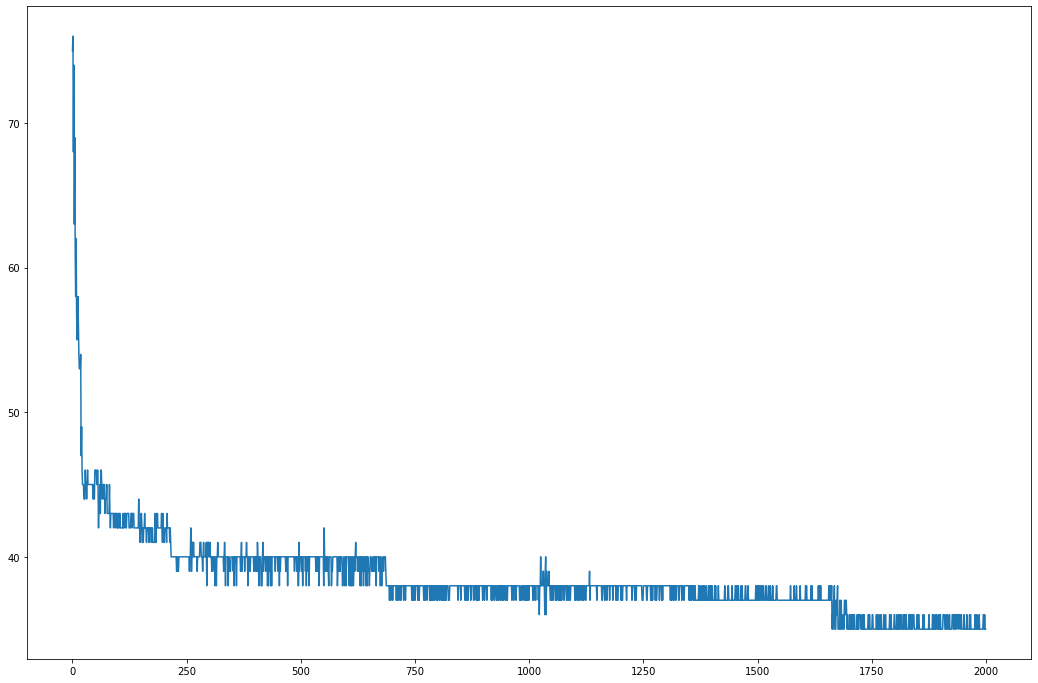

In [43]:


# 36
# aco_1 = AntColonyOptimizer(S, ants=30, evaporation_rate=0.5, intensification=0.8, alpha=1, beta=12, tmax=500, mutation=0.01)
aco_1 = AntColonyOptimizer(S, ants=50, evaporation_rate=0.5, intensification=0.8, alpha=1, beta=12, tmax=2000, mutation=0.01)
aco_1.fit()

In [44]:
x =[{56, 1}, {98, 34, 51, 88, 79}, {66, 51, 87, 71, 73}, {64, 3, 21, 76, 93}, {81, 66, 19, 38, 23}, {96, 97, 2, 83, 8}, {17, 98, 42, 71, 10}, {65, 98, 69, 55, 58}, {49, 52, 57, 92, 61}, {64, 84, 20, 94, 46}, {32, 80, 35, 54}, {96, 66, 68, 86, 11}, {17, 42, 43, 6}, {48, 26, 37, 71}, {5, 85, 89, 26, 75}, {33, 58, 29, 6}, {16, 84, 71, 27, 62}, {83, 86, 73, 61, 47}, {49, 50, 45, 23, 77}, {98, 99, 83, 28, 47}, {2, 67, 9, 60, 47}, {36, 38, 89, 14, 95}, {98, 3, 4, 20, 31}, {98, 56, 41, 61, 14}, {96, 70, 30, 13, 78}, {81, 51, 84, 22, 25}, {96, 64, 39, 60, 61}, {66, 82, 58, 91, 15}, {70, 59, 92, 94, 79}, {24, 11, 44, 28, 78}, {7, 88, 63, 30, 15}, {66, 18, 19, 74, 79}, {49, 90, 40, 10, 12}, {3, 36, 86, 72, 44}, {3, 5, 53, 27, 63}]

y = set.union(*x)
y == set(U)

True

Iteration 1/2000: Best Score = 70, Global Best Score = 70
Iteration 2/2000: Best Score = 79, Global Best Score = 70
Iteration 3/2000: Best Score = 62, Global Best Score = 62
Iteration 4/2000: Best Score = 69, Global Best Score = 62
Iteration 5/2000: Best Score = 74, Global Best Score = 62
Iteration 6/2000: Best Score = 75, Global Best Score = 62
Iteration 7/2000: Best Score = 70, Global Best Score = 62
Iteration 8/2000: Best Score = 59, Global Best Score = 59
Iteration 9/2000: Best Score = 59, Global Best Score = 59
Iteration 10/2000: Best Score = 66, Global Best Score = 59
Iteration 11/2000: Best Score = 51, Global Best Score = 51
Iteration 12/2000: Best Score = 52, Global Best Score = 51
Iteration 13/2000: Best Score = 55, Global Best Score = 51
Iteration 14/2000: Best Score = 56, Global Best Score = 51
Iteration 15/2000: Best Score = 49, Global Best Score = 49
Iteration 16/2000: Best Score = 52, Global Best Score = 49
Iteration 17/2000: Best Score = 43, Global Best Score = 43
Iterat

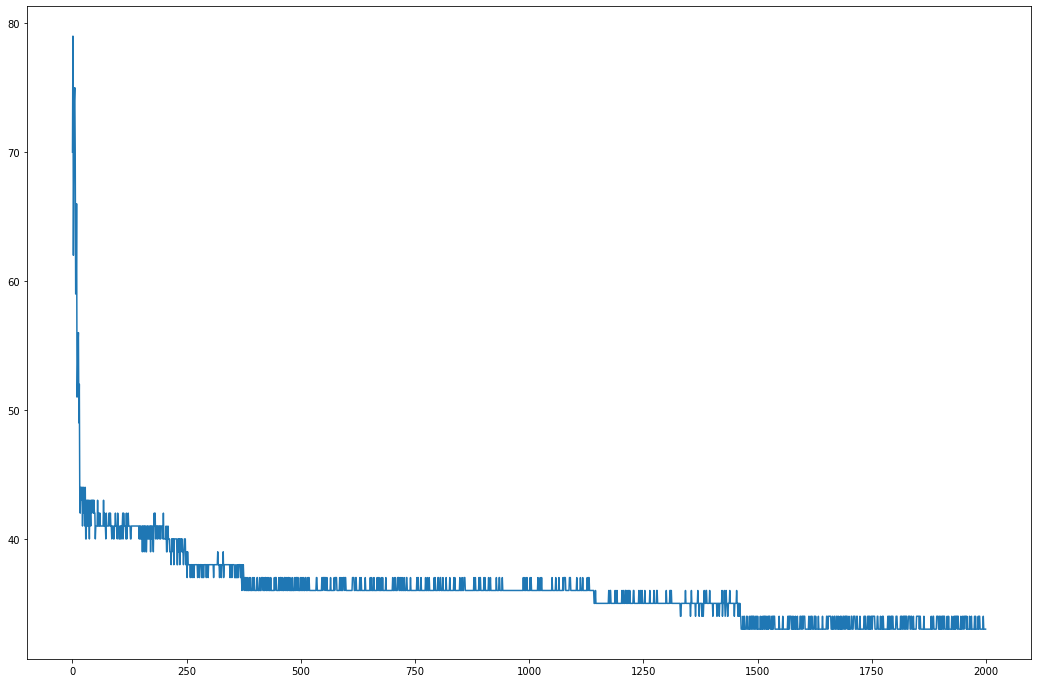

In [6]:
aco_2 = AntColonyOptimizer(S, ants=50, evaporation_rate=0.5, intensification=0.8, alpha=1, beta=12, tmax=2000, mutation=0.01)
aco_2.fit()

Iteration 1/2000: Best Score = 32, Global Best Score = 31
Iteration 2/2000: Best Score = 32, Global Best Score = 31
Iteration 3/2000: Best Score = 32, Global Best Score = 31
Iteration 4/2000: Best Score = 32, Global Best Score = 31
Iteration 5/2000: Best Score = 32, Global Best Score = 31
Iteration 6/2000: Best Score = 32, Global Best Score = 31
Iteration 7/2000: Best Score = 32, Global Best Score = 31
Iteration 8/2000: Best Score = 32, Global Best Score = 31
Iteration 9/2000: Best Score = 32, Global Best Score = 31
Iteration 10/2000: Best Score = 31, Global Best Score = 31
Iteration 11/2000: Best Score = 32, Global Best Score = 31
Iteration 12/2000: Best Score = 31, Global Best Score = 31
Iteration 13/2000: Best Score = 32, Global Best Score = 31
Iteration 14/2000: Best Score = 32, Global Best Score = 31
Iteration 15/2000: Best Score = 31, Global Best Score = 31
Iteration 16/2000: Best Score = 32, Global Best Score = 31
Iteration 17/2000: Best Score = 31, Global Best Score = 31
Iterat

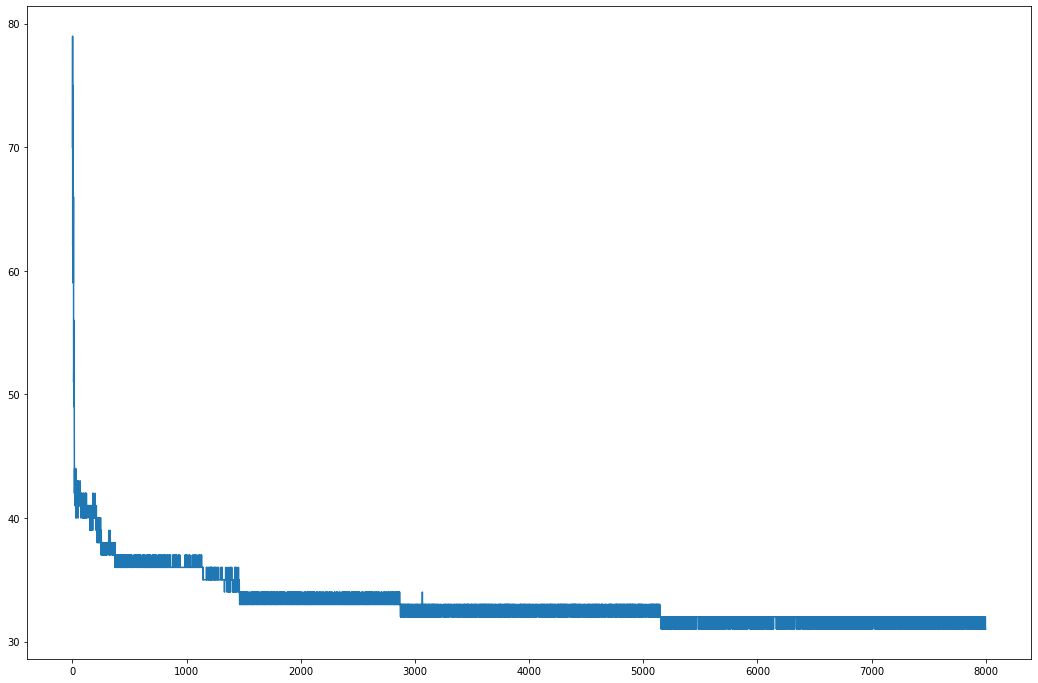

In [9]:
aco_2.fit()